In [1]:
import pandas as pd
import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import os
import time
from multiprocessing import Pool, TimeoutError, Manager
from functools import partial
import pubchempy as pcp
import random
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from IPython.display import clear_output
clear_output()

### Previously Generated Data in Notebook 1

In [3]:
# the file containing the graphs takes up a significant amount of memory

combined_df = pd.read_pickle("../data/partial_archived/both_assays_pubchem_fp_chembl.pickle")
print(f"Number of compounds in loaded file: {len(combined_df):,}")
combined_df.head(2)

Number of compounds in loaded file: 264,965


,pubchem_cid,smiles,tau_inhibitor,app_inhibitor,inchi,inchikey,cmpdname,isosmiles,cmpdsynonym,mw,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,None,None
0,2227226,C1=CC=C(C=C1)OC(=O)C2=CC=CC3=C2N=CC=C3,Inactive,Inactive,InChI=1S/C16H11NO2/c18-16(19-13-8-2-1-3-9-13)1...,GPMDYHKFDVDMLK-UHFFFAOYSA-N,8-Quinolinecarboxylic acid phenyl ester,C1=CC=C(C=C1)OC(=O)C2=CC=CC3=C2N=CC=C3,phenyl quinoline-8-carboxylate|8-quinolinecarb...,249.26,...,19,3,0,0,249.0790,NEUTRAL,C16H11NO2,O=C(Oc1ccccc1)c1cccc2cccnc12,None,None
1,135420967,COC1=CC=C(C=C1)N=CC2=C(C3=CC=CC=C3OC2=O)O,Inactive,Inactive,InChI=1S/C17H13NO4/c1-21-12-8-6-11(7-9-12)18-1...,RUCHDIHJKMGHHH-UHFFFAOYSA-N,"3-[(4-methoxyanilino)methylene]-2H-chromene-2,...",COC1=CC=C(C=C1)N=CC2=C(C3=CC=CC=C3OC2=O)O,364602-08-4|AGN-PC-0LQKC2|Oprea1_586022|MLS000...,295.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
only_tau_num = (combined_df['app_inhibitor'].isnull()).sum()
only_app_num = (combined_df['tau_inhibitor'].isnull()).sum()

in_both = len(combined_df[(~combined_df['app_inhibitor'].isnull()) & \
              (~combined_df['tau_inhibitor'].isnull())])

print(f"{len(combined_df):,} unique compounds were tested between both bioassays")
print(f"{only_app_num:,} compounds were only tested in the APP assay")
print(f"{only_tau_num:,} compounds were only tested in the Tau assay")
print(f"{in_both:,} compounds ({np.round((in_both/len(combined_df)*100), 1)}%) were tested in both assays")

264,965 unique compounds were tested between both bioassays
13,012 compounds were only tested in the APP assay
71,269 compounds were only tested in the Tau assay
180,684 compounds (68.2%) were tested in both assays


In [5]:
# separate into dataframes for active and inactive compounds

active_app = combined_df[combined_df['app_inhibitor'] == 'Active']
active_tau = combined_df[combined_df['tau_inhibitor'] == 'Active']

inactive_app = combined_df[combined_df['app_inhibitor'] == 'Inactive']
inactive_tau = combined_df[combined_df['tau_inhibitor'] == 'Inactive']

inactive_both = combined_df[(combined_df['app_inhibitor'] == 'Inactive') & (combined_df['tau_inhibitor'] == 'Inactive')]

In [6]:
combined_df.columns

Index([                    'pubchem_cid',                          'smiles',
                         'tau_inhibitor',                   'app_inhibitor',
                                 'inchi',                        'inchikey',
                              'cmpdname',                       'isosmiles',
                           'cmpdsynonym',                              'mw',
                                    'mf',                       'polararea',
                            'complexity',                           'xlogp',
                              'heavycnt',                      'hbonddonor',
                              'hbondacc',                        'rotbonds',
                             'morgan_fp',                       'ChEMBL ID',
                                  'Name',                        'Synonyms',
                                  'Type',                       'Max Phase',
                      'Molecular Weight',                         'Targets',

In [7]:
combined_df['Structure Type'].unique()

array(['MOL', nan], dtype=object)

### Graph distributions of important molecular properties

**XlogP**:   
is a program for the prediction of the octanol/water partition coefficients of organic compounds

**Complexity**:  
Estimate of how complicated the structure is, seen from the point of view of both the elements contained and the displayed structural features including symmetry.

In [17]:
combined_df['mw'].isnull().sum() # 0
combined_df['polararea'].isnull().sum() # 0
combined_df['hbonddonor'].isnull().sum() # 0
combined_df['hbondacc'].isnull().sum() # 0
# combined_df['complexity'].isnull().sum() # 0
# combined_df['xlogp'].isnull().sum() # 9520
combined_df['rotbonds'].isnull().sum() # 0


9806

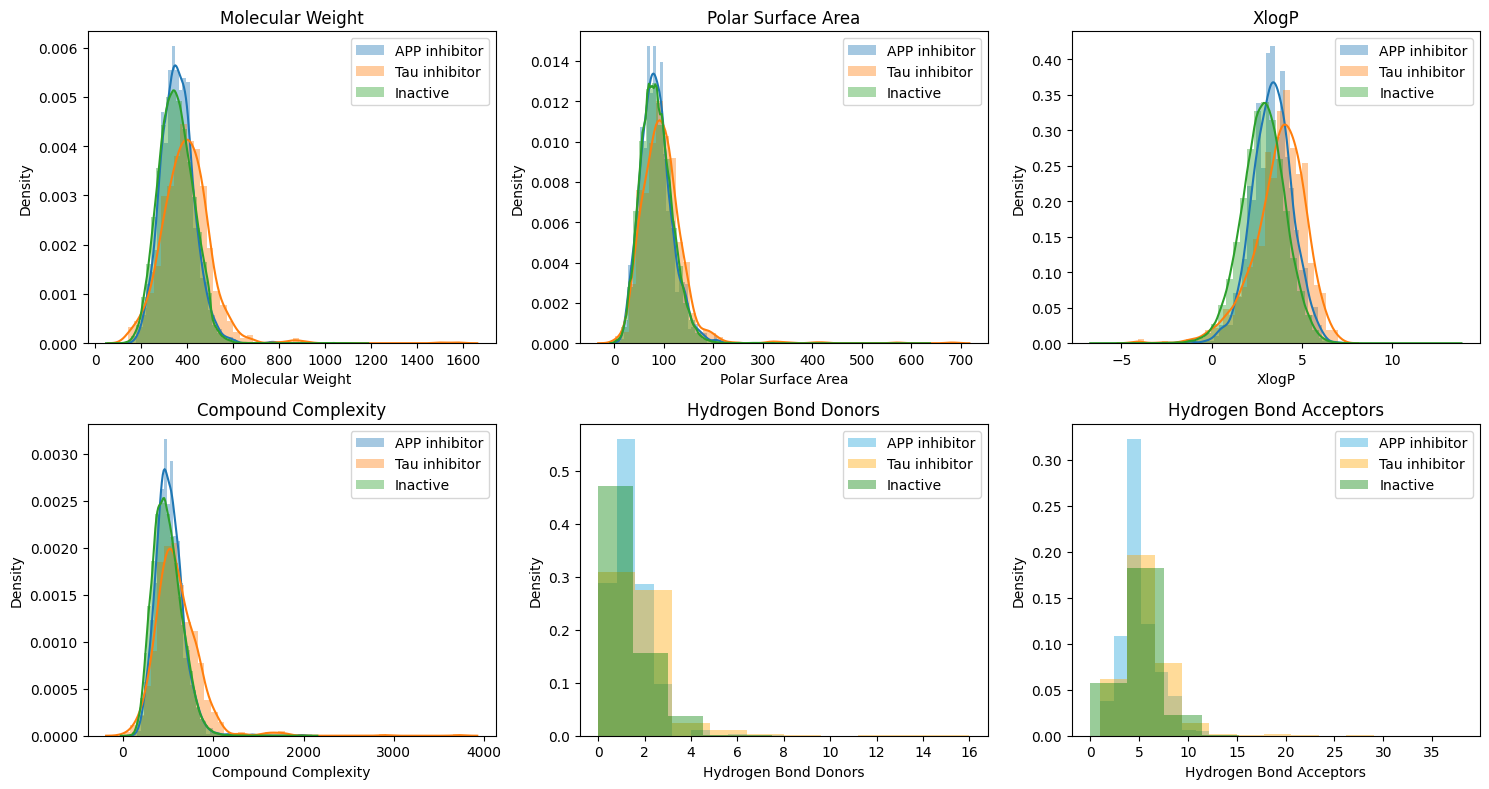

In [30]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False, tight_layout=True)

sns.distplot(active_app['mw'], ax=axes[0, 0], label='APP inhibitor')
sns.distplot(active_tau['mw'], ax=axes[0, 0], label='Tau inhibitor')
sns.distplot(inactive_both['mw'], ax=axes[0, 0], label='Inactive')
axes[0, 0].set_xlabel("Molecular Weight")
axes[0, 0].set_title("Molecular Weight")
axes[0, 0].legend()

sns.distplot(active_app['polararea'], ax=axes[0, 1], label='APP inhibitor')
sns.distplot(active_tau['polararea'], ax=axes[0, 1], label='Tau inhibitor')
sns.distplot(inactive_both['polararea'], ax=axes[0, 1], label='Inactive')
axes[0, 1].set_xlabel("Polar Surface Area")
axes[0, 1].set_title("Polar Surface Area")
axes[0, 1].legend()

sns.distplot(active_app['xlogp'], ax=axes[0, 2], label='APP inhibitor')
sns.distplot(active_tau['xlogp'], ax=axes[0, 2], label='Tau inhibitor')
sns.distplot(inactive_both['xlogp'], ax=axes[0, 2], label='Inactive')
axes[0, 2].set_xlabel("XlogP")
axes[0, 2].set_title("XlogP")
axes[0, 2].legend()

sns.distplot(active_app['complexity'], ax=axes[1, 0], label='APP inhibitor')
sns.distplot(active_tau['complexity'], ax=axes[1, 0], label='Tau inhibitor')
sns.distplot(inactive_both['complexity'], ax=axes[1, 0], label='Inactive')
axes[1, 0].set_xlabel("Compound Complexity")
axes[1, 0].set_title("Compound Complexity")
axes[1, 0].legend()

num_bins=10
sns.histplot(active_app['hbonddonor'], ax=axes[1, 1], label='APP inhibitor',
             stat="density", bins=num_bins, color = 'skyblue', edgecolor='none')
sns.histplot(active_tau['hbonddonor'], ax=axes[1, 1], label='Tau inhibitor',
             stat="density", bins=num_bins, color='orange', alpha=0.4, edgecolor='none')
sns.histplot(inactive_both['hbonddonor'], ax=axes[1, 1], label='Inactive',
             stat="density", bins=num_bins, color = 'green', alpha=0.4, edgecolor='none')
axes[1, 1].set_xlabel("Hydrogen Bond Donors")
axes[1, 1].set_title("Hydrogen Bond Donors")
axes[1, 1].legend()

sns.histplot(active_app['hbondacc'], ax=axes[1, 2], label='APP inhibitor',
             stat="density", bins=num_bins, color = 'skyblue', edgecolor='none')
sns.histplot(active_tau['hbondacc'], ax=axes[1, 2], label='Tau inhibitor',
             stat="density", bins=num_bins, color='orange', alpha=0.4, edgecolor='none')
sns.histplot(inactive_both['hbondacc'], ax=axes[1, 2], label='Inactive',
             stat="density", bins=num_bins, color = 'green', alpha=0.4, edgecolor='none')
axes[1, 2].set_xlabel("Hydrogen Bond Acceptors")
axes[1, 2].set_title("Hydrogen Bond Acceptors")
axes[1, 2].legend()

plt.savefig("EDA_Subplots_Actives_Inactives.png", dpi=400)
plt.show()

### Join ChEMBL Data for Additional Attributes PubChem Does Not Provide

In [6]:
def repull_chembl():

    with open("../data/chembl_full_db.csv", 'r') as handle:
        chembl_file = handle.readlines()

    # chembl_file = chembl_file[:500000]
    chembl_file = [i.replace('"', "") for i in chembl_file]
    chembl_file = [i.replace('\n', "") for i in chembl_file]
    chembl_file = [row.split(";") for row in chembl_file]

    chembl_df = pd.DataFrame(chembl_file)
    chembl_columns = list(chembl_df.iloc[0])
    chembl_df = chembl_df.drop(0)
    chembl_df.columns = chembl_columns
    chembl_df = chembl_df.rename(columns={"Inchi Key": "inchikey"}, errors='ignore')
    chembl_df = chembl_df[chembl_df['Type'] == 'Small molecule']

    return chembl_df

In [7]:
repull_chembl=False

if repull_chembl:
    chembl_df = repull_chembl()
# chembl_df
else:
    chembl_assay_compounds=combined_df.copy()

In [8]:
# 187,056 of the 265,203 compounds are in the ChEMBL Export

# chembl_assay_compounds=combined_df.merge(chembl_df, how='inner', on='inchikey')
# chembl_assay_compounds.columns

In [9]:
keep_columns = ['Name','Smiles','inchikey',
                'Type', 'Molecular Weight','AlogP',
                'Polar Surface Area', 'HBA', 'HBD',
                '#RO5 Violations','#Rotatable Bonds',
                'Passes Ro3','QED Weighted',
                'CX Acidic pKa','CX Basic pKa',
                'CX LogP', 'CX LogD',
                'Aromatic Rings','Structure Type',
                'HBA (Lipinski)','HBD (Lipinski)',
                '#RO5 Violations (Lipinski)', 'app_inhibitor', 'tau_inhibitor']

numeric_columns = ['Molecular Weight','AlogP',
                'Polar Surface Area', 'HBA', 'HBD',
                '#RO5 Violations','#Rotatable Bonds',
                'QED Weighted',
                'CX Acidic pKa','CX Basic pKa',
                'CX LogP', 'CX LogD',
                'Aromatic Rings',
                'HBA (Lipinski)','HBD (Lipinski)',
                '#RO5 Violations (Lipinski)']


# filter to subset of compounds
chembl_assay_compounds = chembl_assay_compounds[keep_columns]

# format to allow future formatting
chembl_assay_compounds = chembl_assay_compounds.replace("", -999)
chembl_assay_compounds = chembl_assay_compounds.replace(np.nan, -999)
chembl_assay_compounds = chembl_assay_compounds.replace("None", -999)
chembl_assay_compounds = chembl_assay_compounds.replace(np.nan, -999)

chembl_assay_compounds[numeric_columns] = chembl_assay_compounds[numeric_columns].apply(pd.to_numeric, axis = 1)
chembl_assay_compounds = chembl_assay_compounds.replace(-999, np.nan)
# chembl_assay_compounds.info()

In [10]:
chembl_active_app = chembl_assay_compounds[chembl_assay_compounds['app_inhibitor'] == 'Active']
chembl_active_tau = chembl_assay_compounds[chembl_assay_compounds['tau_inhibitor'] == 'Active']

chembl_inactive_app = chembl_assay_compounds[chembl_assay_compounds['app_inhibitor'] == 'Inactive']
chembl_inactive_tau = chembl_assay_compounds[chembl_assay_compounds['tau_inhibitor'] == 'Inactive']

chembl_inactive_both = chembl_assay_compounds[(chembl_assay_compounds['app_inhibitor'] == 'Inactive') & (chembl_assay_compounds['tau_inhibitor'] == 'Inactive')]

In [11]:
chembl_assay_compounds.columns

Index(['Name', 'Smiles', 'inchikey', 'Type', 'Molecular Weight', 'AlogP',
       'Polar Surface Area', 'HBA', 'HBD', '#RO5 Violations',
       '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted', 'CX Acidic pKa',
       'CX Basic pKa', 'CX LogP', 'CX LogD', 'Aromatic Rings',
       'Structure Type', 'HBA (Lipinski)', 'HBD (Lipinski)',
       '#RO5 Violations (Lipinski)', 'app_inhibitor', 'tau_inhibitor'],
      dtype='object')

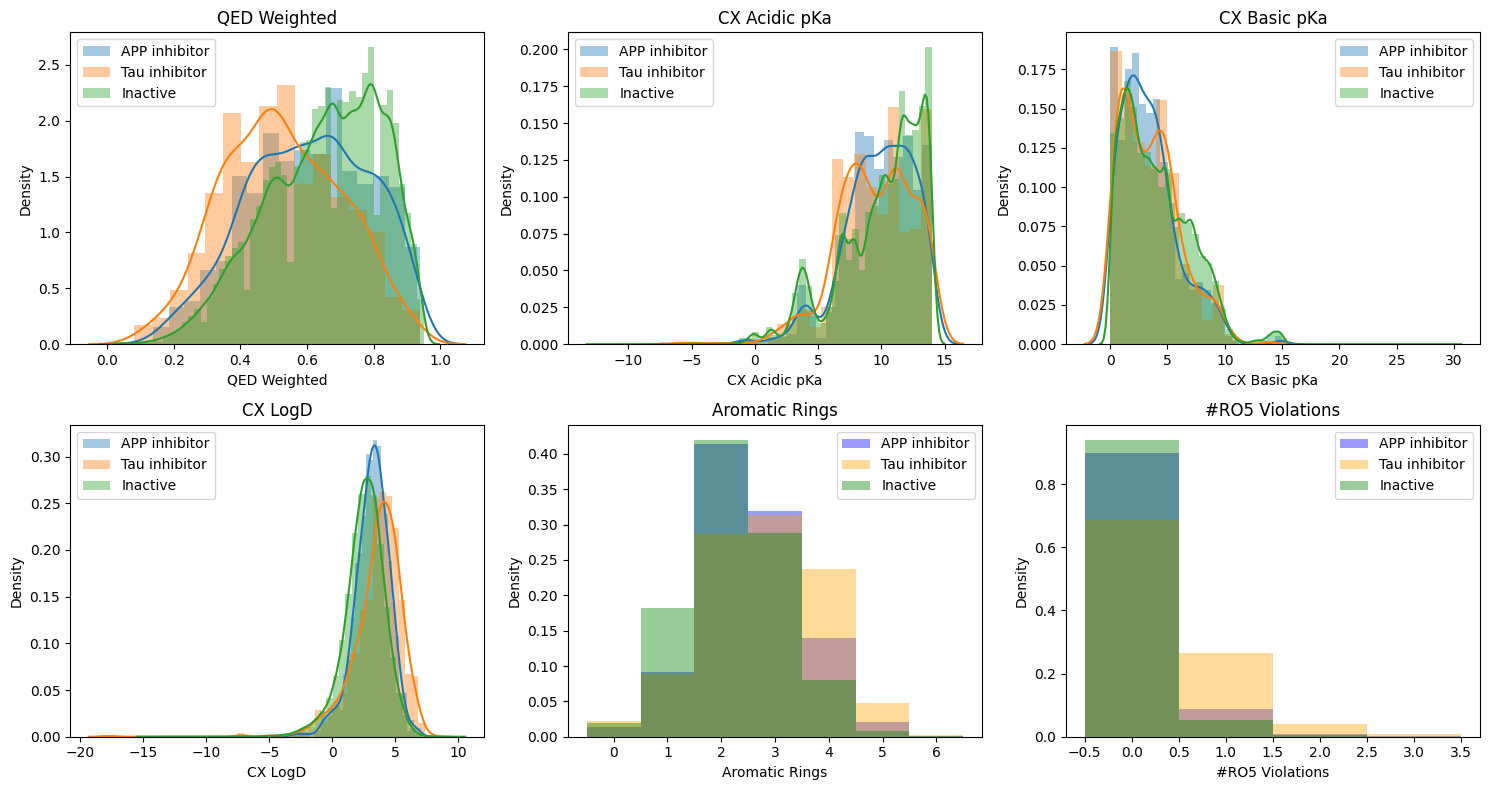

In [12]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False, tight_layout=True)

sns.distplot(chembl_active_app['QED Weighted'], ax=axes[0, 0], label='APP inhibitor')
sns.distplot(chembl_active_tau['QED Weighted'], ax=axes[0, 0], label='Tau inhibitor')
sns.distplot(chembl_inactive_both['QED Weighted'], ax=axes[0, 0], label='Inactive')
axes[0, 0].set_title("QED Weighted")
axes[0, 0].legend()

sns.distplot(chembl_active_app['CX Acidic pKa'], ax=axes[0, 1], label='APP inhibitor')
sns.distplot(chembl_active_tau['CX Acidic pKa'], ax=axes[0, 1], label='Tau inhibitor')
sns.distplot(chembl_inactive_both['CX Acidic pKa'], ax=axes[0, 1], label='Inactive')
axes[0, 1].set_title("CX Acidic pKa")
axes[0, 1].legend()

sns.distplot(chembl_active_app['CX Basic pKa'], ax=axes[0, 2], label='APP inhibitor')
sns.distplot(chembl_active_tau['CX Basic pKa'], ax=axes[0, 2], label='Tau inhibitor')
sns.distplot(chembl_inactive_both['CX Basic pKa'], ax=axes[0, 2], label='Inactive')
axes[0, 2].set_title("CX Basic pKa")
axes[0, 2].legend()

sns.distplot(chembl_active_app['CX LogD'], ax=axes[1, 0], label='APP inhibitor')
sns.distplot(chembl_active_tau['CX LogD'], ax=axes[1, 0], label='Tau inhibitor')
sns.distplot(chembl_inactive_both['CX LogD'], ax=axes[1, 0], label='Inactive')
axes[1, 0].set_title("CX LogD")
axes[1, 0].legend()

sns.histplot(chembl_active_app['Aromatic Rings'], ax=axes[1, 1], label='APP inhibitor',
             stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none', discrete = True)
sns.histplot(chembl_active_tau['Aromatic Rings'], ax=axes[1, 1], label='Tau inhibitor',
             stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none', discrete = True)
sns.histplot(chembl_inactive_both['Aromatic Rings'], ax=axes[1, 1], label='Inactive',
             stat="density", bins=15, color = 'green', alpha=0.4, edgecolor='none', discrete = True)
axes[1, 1].set_title("Aromatic Rings")
axes[1, 1].legend()

sns.histplot(chembl_active_app['#RO5 Violations'], ax=axes[1, 2], label='APP inhibitor',
             stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none', discrete = True)
sns.histplot(chembl_active_tau['#RO5 Violations'], ax=axes[1, 2], label='Tau inhibitor',
             stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none', discrete = True)
sns.histplot(chembl_inactive_both['#RO5 Violations'], ax=axes[1, 2], label='Inactive',
             stat="density", bins=15, color = 'green', alpha=0.4, edgecolor='none', discrete = True)
axes[1, 2].set_title("#RO5 Violations")
axes[1, 2].legend()

plt.show()

### Scaffold Analysis

In [4]:
no_salts=pd.read_pickle("../data/cleaned_smiles_both_assays_pubchem_fp_chembl_2023_Dec24.pickle")
no_salts

,pubchem_cid,smiles,tau_inhibitor,app_inhibitor,inchi,inchikey,cmpdname,isosmiles,cmpdsynonym,mw,...,Structure Type,Inorganic Flag,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,cleaned_smiles
264893,16717692,CCC1=C2/C=C\3/C(=C4C(=O)C(C(=C4[N-]3)C5=C(C(=C...,Active,NaN,InChI=1S/C34H33N4O5.Cu.2Na/c1-7-18-14(3)21-11-...,XSEXFOMVYDMIDW-WSXKCGQDSA-I,CHLOROPHYLLIDE Cu COMPLEX Na SALT,CCC1=C2/C=C\\3/C(=C4C(=O)C(C(=C4[N-]3)C5=C(C(=...,CHLOROPHYLLIDE Cu COMPLEX Na SALT|SPECTRUM1505...,682.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C=Cc1c(C)/c2[nH]/c1=C\c1[nH]c(c(CC)c1C)/C=c1\[...
78316,6602639,C1CN=C(N(C1=O)CC2=CC=CC=C2)NC3=CC=C(C=C3)F.Cl,Inactive,Inactive,InChI=1S/C17H16FN3O.ClH/c18-14-6-8-15(9-7-14)2...,LMWSQTZOTHZRPO-UHFFFAOYSA-N,"3-Benzyl-2-(4-fluoro-phenylamino)-5,6-dihydro-...",C1CN=C(N(C1=O)CC2=CC=CC=C2)NC3=CC=C(C=C3)F.Cl,SMR000006136|MLS000034571|CHEMBL1312669|3-Benz...,333.80,...,MOL,-1,22,4,1,0,297.1277,NEUTRAL,C17H17ClFN3O,O=C1CCN=C(Nc2ccc(F)cc2)N1Cc1ccccc1
78321,2935420,COC1=CC=C(C=C1)OCCCN2CCCCCC2.C(=O)(C(=O)O)O,Inactive,Inactive,InChI=1S/C16H25NO2.C2H2O4/c1-18-15-7-9-16(10-8...,PBSAVHXNRIADDY-UHFFFAOYSA-N,1-[3-(4-Methoxyphenoxy)propyl]azepane oxalate,COC1=CC=C(C=C1)OCCCN2CCCCCC2.C(=O)(C(=O)O)O,SMR000143093|MLS000594034|CHEMBL1497945|HMS236...,353.40,...,MOL,-1,19,3,0,0,263.1885,BASE,C18H27NO6,COc1ccc(OCCCN2CCCCCC2)cc1
78578,15944981,C1=CC=C(C=C1)C[N+]2=CC=CC(=C2)C3=CC=CC=C3.[Cl-],Inactive,Inactive,InChI=1S/C18H16N.ClH/c1-3-8-16(9-4-1)14-19-13-...,BJXCSZPOQOCAKW-UHFFFAOYSA-M,CID 15944981,C1=CC=C(C=C1)C[N+]2=CC=CC(=C2)C3=CC=CC=C3.[Cl-],MLS000698950|SMR000228374|CHEMBL1586226|HMS256...,281.80,...,MOL,-1,19,1,0,0,246.1277,NEUTRAL,C18H16ClN,c1ccc(C[n+]2cccc(-c3ccccc3)c2)cc1
78828,16196875,CCN(CC)CCNS(=O)(=O)C1=CC=C(C=C1)C(=O)OCC.Cl,Inactive,Inactive,InChI=1S/C15H24N2O4S.ClH/c1-4-17(5-2)12-11-16-...,OJHNSGAWAFXCKA-UHFFFAOYSA-N,Ethyl 4-[2-(diethylamino)ethylsulfamoyl]benzoa...,CCN(CC)CCNS(=O)(=O)C1=CC=C(C=C1)C(=O)OCC.Cl,MLS001002679|CHEMBL1304013|AKOS008008928|SMR00...,364.90,...,MOL,-1,22,6,1,0,328.1457,NEUTRAL,C15H25ClN2O4S,CCOC(=O)c1ccc(S(=O)(=O)NCCN(CC)CC)cc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92716,7120749,CC1=C(C(=CC=C1)NC(=O)C2=C(SC(=C2)Cl)Cl)C,Inactive,Inactive,InChI=1S/C13H11Cl2NOS/c1-7-4-3-5-10(8(7)2)16-1...,OTJQARSPUSRQPU-UHFFFAOYSA-N,"2,5-dichloro-N-(2,3-dimethylphenyl)thiophene-3...",CC1=C(C(=CC=C1)NC(=O)C2=C(SC(=C2)Cl)Cl)C,"2,5-dichloro-N-(2,3-dimethylphenyl)thiophene-3...",300.20,...,MOL,-1,18,2,1,0,298.9938,NEUTRAL,C13H11Cl2NOS,CC1=C(C(=CC=C1)NC(=O)C2=C(SC(=C2)Cl)Cl)C
92717,12006015,C1CC2=CC=CC=C2N(C1)C(=O)CSC3=NN4C(=NN=C4C5=CC(...,Inactive,Inactive,InChI=1S/C22H18FN5OS/c23-17-8-3-6-16(13-17)22-...,XBPLTFIKHVYSDD-UHFFFAOYSA-N,"1-(3,4-dihydroquinolin-1(2H)-yl)-2-((3-(3-fluo...",C1CC2=CC=CC=C2N(C1)C(=O)CSC3=NN4C(=NN=C4C5=CC(...,"SMR000236266|MLS000720352|852374-51-7|1-(3,4-d...",419.50,...,MOL,-1,30,6,0,0,419.1216,NEUTRAL,C22H18FN5OS,C1CC2=CC=CC=C2N(C1)C(=O)CSC3=NN4C(=NN=C4C5=CC(...
92718,648798,C1CCC(CC1)NC(=O)C2=CC=C(C=C2)S(=O)(=O)NCC3=CN=...,Inactive,Inactive,InChI=1S/C19H23N3O3S/c23-19(22-17-6-2-1-3-7-17...,CNSDZXRUJHLHSO-UHFFFAOYSA-N,N-Cyclohexyl-4-[(pyridin-3-ylmethyl)-sulfamoyl...,C1CCC(CC1)NC(=O)C2=CC=C(C=C2)S(=O)(=O)NCC3=CN=...,MLS000070920|ASN 05061982|CHEMBL1594995|N-Cycl...,373.50,...,MOL,-1,26,6,2,0,373.1460,NEUTRAL,C19H23N3O3S,C1CCC(CC1)NC(=O)C2=CC=C(C=C2)S(=O)(=O)NCC3=CN=...
92941,2161874,C1CN(C2=CC=CC=C21)C(=O)COC(=O)C3=C(C=CC(=N3)Cl)Cl,Inactive,Inactive,InChI=1S/C16H12Cl2N2O3/c17-11-5-6-13(18)19-15(...,GOTSRIVRDVJTPQ-UHFFFAOYSA-N,"2-(2,3-dihydro-1H-indol-1-yl)-2-oxoethyl 3,6-d...",C1CN(C2=CC=CC=C21)C(=O)COC(=O)C3=C(C=CC(=N3)Cl)Cl,775311-30-3|MLS000517417|CHEMBL1442107|DTXSID9...,351.20,...,MOL,-1,23,5,0,0,350.0225,NEUTRAL,C16H12Cl2N2O3,C1CN(C2=CC=CC=C21)C(=O)COC(=O)C3=C(C=CC(=N3)Cl)Cl


## Principal Component Analysis

Before performing PCA - need to convert the representation of the fingerprints from string to a list of integers

In [7]:
## 5 minutes
def generate_int_fp(lst, data):

    lst.append(list(map(int, data)))

morgan_df_vals = no_salts['morgan_fp'].values.tolist()

if __name__ == '__main__':

    pbar = tqdm(total=len(no_salts)/8)
    dfs_list = Manager().list()
    pool = Pool(processes=8)
    res = pool.map_async(partial(generate_int_fp, dfs_list), morgan_df_vals)
    res.wait()
    pbar.close()
    fp_df = pd.DataFrame(list(dfs_list))

fp_df.head()

  0%|          | 0/33119.375 [00:16<?, ?it/s]


  0%|          | 0/33119.375 [00:49<?, ?it/s]


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
fp_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
import sklearn
# from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

n_components = 3
pca = PCA

pca = PCA(n_components=n_components)
pca_arr = pca.fit_transform(fp_df)

In [16]:
pca_arr
combined_df=no_salts.copy()

In [19]:
no_salts.columns

Index(['pubchem_cid', 'smiles', 'tau_inhibitor', 'app_inhibitor', 'inchi',
       'inchikey', 'cmpdname', 'isosmiles', 'cmpdsynonym', 'mw', 'mf',
       'polararea', 'complexity', 'xlogp', 'heavycnt', 'hbonddonor',
       'hbondacc', 'rotbonds', 'morgan_fp', 'ChEMBL ID', 'Name', 'Synonyms',
       'Type', 'Max Phase', 'Molecular Weight', 'Targets', 'Bioactivities',
       'AlogP', 'Polar Surface Area', 'HBA', 'HBD', '#RO5 Violations',
       '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted', 'CX Acidic pKa',
       'CX Basic pKa', 'CX LogP', 'CX LogD', 'Aromatic Rings',
       'Structure Type', 'Inorganic Flag', 'Heavy Atoms', 'HBA (Lipinski)',
       'HBD (Lipinski)', '#RO5 Violations (Lipinski)',
       'Molecular Weight (Monoisotopic)', 'Molecular Species',
       'Molecular Formula', 'cleaned_smiles'],
      dtype='object')

In [ ]:
# notice the first element is not the highest - the following link discusses:
# https://stackoverflow.com/questions/61744485/why-sklearn-truncatedsvds-explained-variance-ratios-are-not-in-descending-order
# svd.explained_variance_

In [13]:
plt.style.use('ggplot')

num_components = list(range(1, n_components+1))

display_images = False

if display_images:
    plt.bar(num_components, pca.explained_variance_ratio_)
    plt.title("Principal Components Explained Variance", fontsize=14)
    plt.xlabel("Principal Componenent")
    plt.ylabel("Explained Variance by Component")
    print("The explained variance of {} principal components is {:.3}%\n".format(len(num_components),
                                                                              pca.explained_variance_ratio_.sum()*100))

    plt.show()

In [17]:
combined_df['first_component_pca'] = [i[0] for i in pca_arr]
combined_df['second_component_pca'] = [i[1] for i in pca_arr]
combined_df['third_component_pca'] = [i[2] for i in pca_arr]

## Reassign with PCA columns for graphing
active_app = combined_df[combined_df['app_inhibitor'] == 'Active']
active_tau = combined_df[combined_df['tau_inhibitor'] == 'Active']

In [31]:
combined_df=pd.read_pickle("/home/paperspace/Desktop/DL_Project/data/cleaned_smiles_both_assays_pubchem_fp_chembl_pca_2023_Dec25.pickle")

In [32]:
active_app = combined_df[combined_df['app_inhibitor'] == 'Active']
active_tau = combined_df[combined_df['tau_inhibitor'] == 'Active']

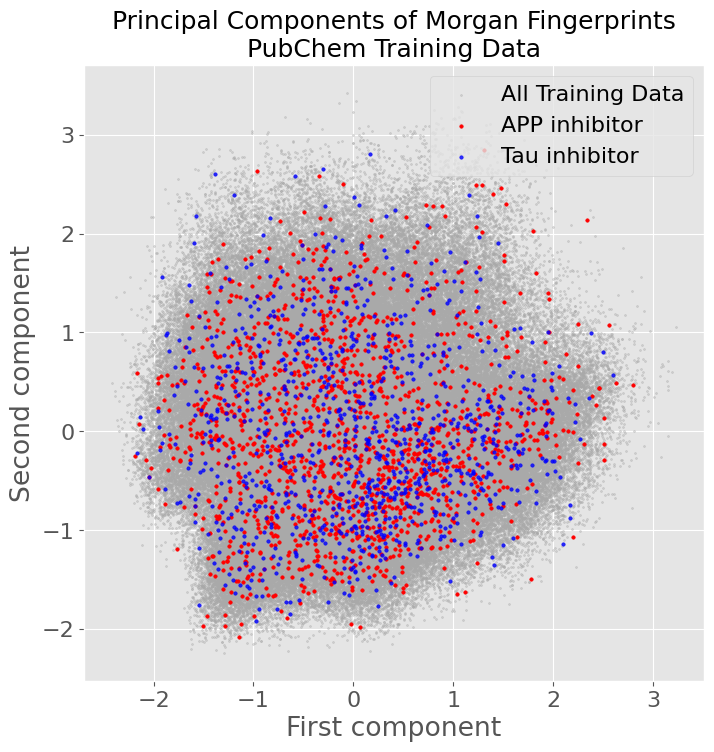

In [37]:
plt.style.use('ggplot')
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.rcParams.update({'font.size': 16})

plt.scatter(combined_df['first_component_pca'], combined_df['second_component_pca'], label = 'All Training Data', s=2, color = 'darkgray', alpha=0.4)
plt.scatter(active_app['first_component_pca'], active_app['second_component_pca'], label='APP inhibitor', s=6, color = 'red')
plt.scatter(active_tau['first_component_pca'], active_tau['second_component_pca'], label = 'Tau inhibitor', s=6, alpha=0.8, color='blue')
plt.xlabel("First component")
plt.ylabel("Second component")
plt.legend()
plt.title("Principal Components of Morgan Fingerprints\nPubChem Training Data", size=18)
plt.savefig("EDA_PCA.png", dpi=400)
plt.show()

In [ ]:
### visualize with alpha to see dense regions
plt.scatter(combined_df['first_component_pca'], combined_df['second_component_pca'], label = 'All compounds', s=2, color = 'darkblue', alpha=0.02)

### Save the PCA Model to Apply to Prediction Set

In [12]:
import pickle

# save
with open('pca_model_smiles_cleaned_2023Dec25.pkl','wb') as f:
    pickle.dump(pca,f)

In [22]:
import pickle

# save
with open('cleaned_smiles_both_assays_pubchem_fp_chembl_pca_2023_Dec25.pickle','wb') as f:
    pickle.dump(combined_df,f)

# no_salts=pd.read_pickle("../data/cleaned_smiles_both_assays_pubchem_fp_chembl_2023_Dec24.pickle")

In [32]:
# testing load - works
# with open('pca_model_2023Ded22.pkl', 'rb') as f:
#     pca2 = pickle.load(f)

In [35]:
# combined_df.drop(["dc_graph", None], axis=1, errors='ignore').to_pickle('../data/full_data_fp_pca_2023Dec22.pickle', compression='infer', storage_options=None)

In [1]:
import pandas as pd
import pickle

test_load=pd.read_pickle("/home/paperspace/Desktop/validation_split_app_2023Dec27.pickle")
test_load

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/paperspace/.local/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


,X,y,w,ids
0,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,17
1,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,42
2,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,45
3,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,49
4,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,54
...,...,...,...,...
19365,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,193629
19366,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,193641
19367,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,193642
19368,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,193667


In [4]:
test_load['X'].loc[0]==test_load['X'].loc[1]

False

In [5]:
copy=pd.read_pickle("/home/paperspace/Desktop/validation_split_app_2023Dec27.pickle")

In [8]:
test_load

,X,y,w,ids
0,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,17
1,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,42
2,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,45
3,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,49
4,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,54
...,...,...,...,...
19365,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,193629
19366,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,193641
19367,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,193642
19368,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0,1.008271,193667


In [11]:
copy['ids'].duplicated().sum()

0

In [6]:
test_load['X'].loc[0]==copy['X'].loc[0]

False

In [12]:
dir(test_load['X'].loc[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_deg_sort',
 'agglomerate_mols',
 'atom_features',
 'canon_adj_list',
 'deg_adj_lists',
 'deg_block_indices',
 'deg_id_list',
 'deg_list',
 'deg_slice',
 'deg_start',
 'degree_list',
 'get_adjacency_list',
 'get_atom_features',
 'get_atoms_with_deg',
 'get_deg_adjacency_lists',
 'get_deg_slice',
 'get_null_mol',
 'get_num_atoms',
 'get_num_atoms_with_deg',
 'max_deg',
 'membership',
 'min_deg',
 'n_atoms',
 'n_feat']

In [19]:
test_load['X'].loc[0].get_adjacency_list() == test_load['X'].loc[1].get_adjacency_list()

False